In [1]:
import numpy as np
import matplotlib.pyplot as plt
import agama

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

In [3]:
'''Functions to calculate energy and frequencies in isochrone potential'''

def H(J_r, L):
    return -0.5*GM**2 / (J_r + 0.5*(L + np.sqrt(L**2 + 4*GM*b)))**2

def calc_Omega_r(J_r, L):
    return GM**2 / (J_r + 0.5*(L + np.sqrt(L**2 + 4*GM*b)))**3

def calc_Omega_phi(J_r, L, J_phi):
    return 0.5*(1 + L/np.sqrt(L**2 + 4*GM*b)) * calc_Omega_r(J_r, L) * np.sign(J_phi)

In [4]:
'''Choose potential parameters'''
import astropy.units as u
from astropy.constants import G

# Choose Solar radius and local circular velocity
r0 = 8.2
v0 = 238

# Choose scale radius and bar pattern speed
b = 3

# Calculate mass required to satisfy above requirements
a = np.sqrt(b**2 + r0**2)
GM = v0**2 * ((b+a)**2 * a)/r0**2
M = (GM*(u.km/u.s)**2*u.kpc / G).to(u.Msun).value

def Phi(r):
    return -GM / (b + np.sqrt(b**2 + r**2))

def v_c(r):
    a = np.sqrt(b**2 + r**2)
    return (GM * r**2 / ((b + a)**2 * a))**0.5

pot = agama.Potential(type='isochrone', mass=M, scaleRadius=b)

In [ ]:
'''Define bar potential radial profile'''

# Set bar strength and scale length
A = 0.02
b_bar = 0.28

def Phi_bar(r, Omega_b):
    # Calculate corotation radius
    rgrid = np.linspace(0.01, 20, 1000)
    Omega_c = v_c(rgrid) / rgrid
    R_CR = rgrid[np.argmin(abs(Omega_c - Omega_b))]

    return -0.5 * A * v0**2 * (r / R_CR)**2 * ((b_bar + 1) / (b_bar + r / R_CR))**5


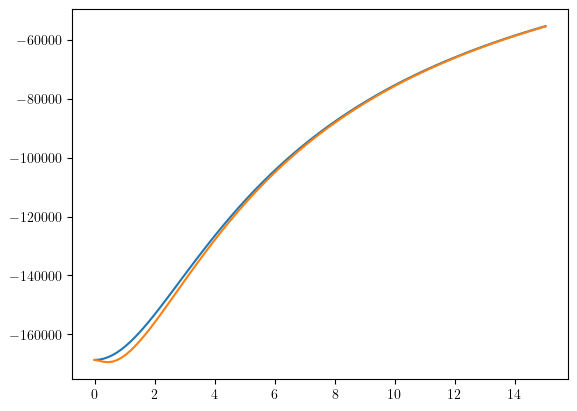

In [8]:
Rgrid = np.linspace(0, 15, 101)

Phi_b = Phi_bar(Rgrid, 35)

# plt.plot(Rgrid, Phi_b)

plt.plot(Rgrid, Phi(Rgrid))

plt.plot(Rgrid, Phi(Rgrid) + Phi_b)

In [10]:
'''Calculate orbits'''

L_z = 100
J_r = 100

def calc_orbit(L_z, J_r, phi_peri):
    L = np.abs(L_z)
    J_phi = L_z

    E = H(J_r, L)
    Omega_r = calc_Omega_r(J_r, L)
    Omega_phi = calc_Omega_phi(J_r, L, J_phi)

    # Calculate theta_r from uniform grid in eta
    N = 101
    N_r_period = 5

    eta = np.linspace(0, 1, N+1) * 2*np.pi*N_r_period
    eta_over_pi = eta / np.pi
    c = GM/(-2*E) - b
    e = (1 - L**2/(GM*c) * (1 + b/c))**0.5

    theta_r = eta - e*c/(c + b) * np.sin(eta)

    # Calculate radius
    s = 2 + c/b * (1 - e*np.cos(eta))
    r = b*np.sqrt((s-1)**2 - 1)

    # Calculate theta and phi
    theta_phi = Omega_phi/Omega_r * theta_r + phi_peri

    phi_shift = 0.5*np.pi*(eta_over_pi - eta_over_pi % 4)*(1 + 1/np.sqrt(1 + 4*GM*b/L**2))*np.sign(J_phi)

    phi = theta_phi - Omega_phi/Omega_r * theta_r + np.sign(J_phi) * (np.arctan2(np.sqrt((1+e)/(1-e)) * np.sin(eta/2), np.cos(eta/2))%(2*np.pi) + 1/np.sqrt(1 + 4*GM*b/L**2) * (np.arctan2(np.sqrt((1+e+2*b/c)/(1-e+2*b/c)) * np.sin(eta/2), np.cos(eta/2))%(2*np.pi))) + phi_shift

    return r, phi, theta_r, theta_phi, Omega_r, Omega_phi


In [11]:
'''Calculate change in Lz per orbit'''
import matplotlib.colors as mcolors

def calc_Delta_Lz(L_z, J_r, phi_peri, Omega_b):
    r, phi, theta_r, theta_phi, Omega_r, Omega_phi = calc_orbit(L_z, J_r, phi_peri)

    integrand = Phi_bar(r, Omega_b) * np.sin(2*(phi - Omega_b/Omega_r * theta_r))

    Delta_Lz = 2 / Omega_r * np.trapz(integrand, theta_r)

    return Delta_Lz

def calc_D(L_z, J_r, Omega_b):
    phi_peri_grid = np.linspace(0, 2*np.pi, 101)
    Delta_Lz_grid = np.zeros(len(phi_peri_grid))
    for i in range(len(phi_peri_grid)):
        Delta_Lz_grid[i] = calc_Delta_Lz(L_z, J_r, phi_peri_grid[i], Omega_b)

    Omega_r = calc_Omega_r(J_r, abs(L_z))
    tau = 2*np.pi / Omega_r

    return 0.5 * np.mean(Delta_Lz_grid**2) / tau


In [12]:
Omega_b = 35

L_z = np.random.normal(0, 1000, 1000)
L = np.abs(L_z)
J_r = np.abs(np.random.normal(0, 1000, 1000))
E = H(J_r, L)

D = np.zeros(len(L_z))

for i in range(len(L_z)):
    D[i] = calc_D(L_z[i], J_r[i], Omega_b)

(0.0, 6000.0)

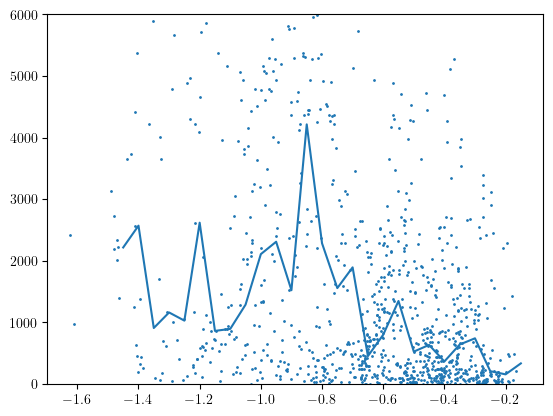

In [13]:
from scipy.stats import binned_statistic

tbar = 8
spread = 2*D**0.5 * tbar

plt.scatter(E/1e5, spread, s=1)
E_bins = np.linspace(-1.5, 0, 31)

D_median = binned_statistic(E/1e5, spread, statistic='median', bins=E_bins)[0]

plt.plot(E_bins[1:], D_median)

plt.ylim(0, 6000)

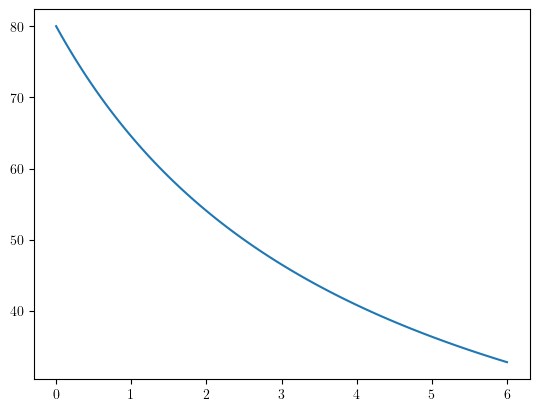

In [20]:
'''Calculate mean diffusion coefficient across time for decelerating bar'''

eta = 0.003
Omega_b_0 = 80

def Omega_b_slow(t):
    return Omega_b_0 / (1 + eta * Omega_b_0 * t)

t = np.linspace(0, 6, 101)
Omega_b = Omega_b_slow(t)

plt.plot(t, Omega_b)

# Generate points from GC-like DF
Nbody = 200
df_GC = agama.DistributionFunction(type='DoublePowerLaw', norm=1e9, slopeOut=5.03, slopeIn=1.23, steepness=1.08, coefJrOut=0.65, coefJzOut=1.32, coefJrIn=1.86, coefJzIn=1.01, J0=10**3.08, rotFrac=0)
xv, mass = agama.GalaxyModel(pot, df_GC).sample(Nbody)

af = agama.ActionFinder(pot)
act = af(xv)

L_z = act[:,2]
J_r = act[:,0]

# L_z = np.random.normal(0, 1000, 100)
L = np.abs(L_z)
# J_r = np.abs(np.random.normal(0, 1000, 100))
E = H(J_r, L)


In [21]:
'''Calculate diffusion coefficient and weighted means of Omega'''

D = np.zeros((len(L_z), len(t)))
D_mean = np.zeros(len(L_z))
Omega_b_mean = np.zeros(len(L_z))
Omega_b2_mean = np.zeros(len(L_z))

for i in range(len(L_z)):
    for j in range(len(t)):
        D[i,j] = calc_D(L_z[i], J_r[i], Omega_b[j])
    
    D_mean[i] = np.mean(D[i])
    Omega_b_mean[i] = np.average(Omega_b, weights=D[i])
    Omega_b2_mean[i] = np.average(Omega_b**2, weights=D[i])

alpha = Omega_b2_mean / Omega_b_mean**2 - 1

[0.04491033 0.01115365 0.03638298 0.02759142 0.02220225 0.06893839
 0.01033415 0.00869811 0.08802949 0.00656177 0.04121508 0.00648734
 0.06293906 0.04786613 0.03293547 0.01216053 0.03013664 0.02227
 0.05529227 0.03887147 0.07197087 0.03102858 0.0226031  0.01678107
 0.00833039 0.01465188 0.05764125 0.03827892 0.05195141 0.04771228
 0.07291416 0.06351566 0.03608979 0.01737469 0.06818615 0.08027545
 0.01832396 0.02501927 0.08056272 0.0141479  0.02738944 0.11672253
 0.04688059 0.0373508  0.03242344 0.03558728 0.03129251 0.02028829
 0.00829242 0.01914452 0.0824818  0.07934407 0.04213241 0.03548106
 0.06010439 0.0123067  0.00639735 0.03212511 0.00566675 0.01980311
 0.00611241 0.04887757 0.00509809 0.03811493 0.03414325 0.05646951
 0.01459672 0.02761155 0.009129   0.05456054 0.03588536 0.01365155
 0.03490826 0.04367522 0.04939649 0.0392575  0.0742911  0.00605381
 0.06374474 0.05051658 0.0075729  0.01565169 0.02092292 0.00878799
 0.07258092 0.0226254  0.01252069 0.03134596 0.03343014 0.0193692

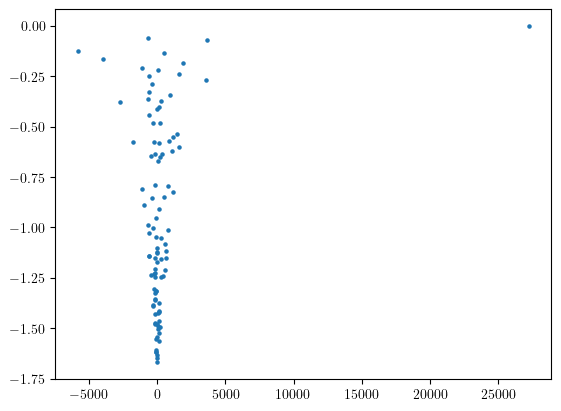

In [17]:
print(alpha)

plt.scatter(L_z, E/1e5, s=5)

(-1.8, 0.0)

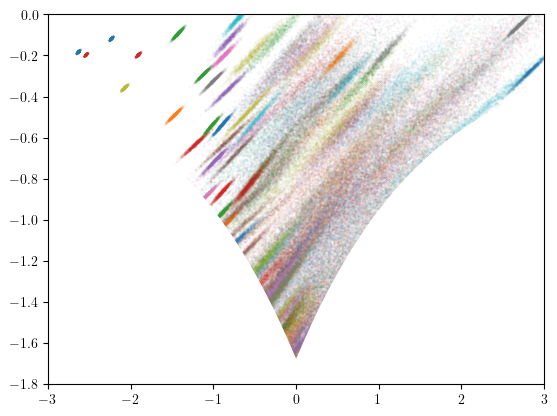

In [25]:
'''Draw samples from covariance matrix'''


for i in range(len(L_z)):
    cov = 2 * D_mean[i] * t[-1] * np.array([[1, Omega_b_mean[i]], [Omega_b_mean[i], Omega_b2_mean[i]]])
    samples = np.random.multivariate_normal((L_z[i], E[i]), cov, 1000)

    plt.scatter(samples[:,0]/1e3, samples[:,1]/1e5, s=0.1, alpha=0.1)


# Calculate energy of circular planar orbits
rgrid = np.linspace(0.1, 40, 1000)
vcirc = v_c(rgrid)
Lz_circ = rgrid * vcirc
E_circ = 0.5 * vcirc**2 + Phi(rgrid)

plt.fill_between(Lz_circ/1e3, -5, E_circ/1e5, color='w')
plt.fill_between(-Lz_circ/1e3, -5, E_circ/1e5, color='w')

plt.xlim(-3, 3)
plt.ylim(-1.8, 0)



Text(0, 0.5, '$E$ [$10^5$ (km/s)$^2$]')

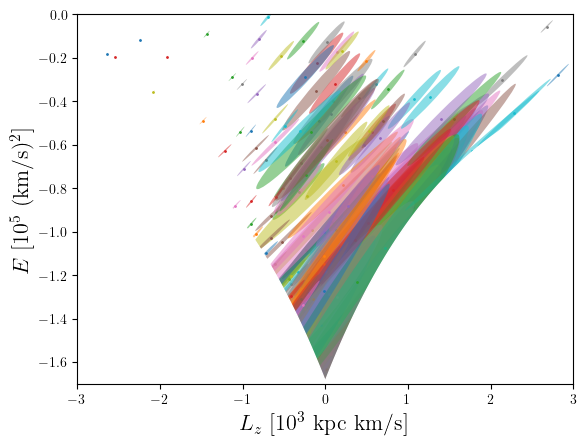

In [ ]:
from matplotlib import patches as mpatches

fig, ax = plt.subplots()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Omega_0 = 1e2
Lz_scale = 1e3

for i in range(len(L_z)):
    centre = (L_z[i]/1e3, E[i]/1e5)
    p = Omega_b_mean[i] / Omega_0
    major_ax = 2*(2*D_mean[i]*t[-1] * (1 + p**2) * (1 + p**4 / (1 + p**2)**2 * alpha[i]))**0.5 / Lz_scale
    minor_ax = 2*(2*D_mean[i]*t[-1] * p**2 / (1 + p**2) * alpha[i])**0.5 / Lz_scale
    gradient = (1 + p**2 / (1 + p**2) * alpha[i]) * Omega_b_mean[i] / Omega_0
    angle_deg = np.arctan(gradient) * 180/np.pi

    # print(centre)
    # print(major_ax)
    # print(minor_ax)
    # print(angle_deg)

    patch = mpatches.Ellipse(xy=centre, width=major_ax, height=minor_ax, angle=angle_deg, fc=colors[i%10], alpha=0.5)#, fc='none', ls='solid', ec='g', lw='3.')
    ax.add_patch(patch)

    ax.scatter(L_z[i]/1e3, E[i]/1e5, s=1, c=colors[i%10])

# Plot resonances



ax.fill_between(Lz_circ/1e3, -5e6, E_circ/1e5, color='w')
ax.fill_between(-Lz_circ/1e3, -5e6, E_circ/1e5, color='w')

ax.set_xlim(-3, 3)
ax.set_ylim(-1.7, 0)

ax.set_xlabel('$L_z$ [$10^3$ kpc km/s]', fontsize=16)
ax.set_ylabel('$E$ [$10^5$ (km/s)$^2$]', fontsize=16)

(-40.0, 100.0)

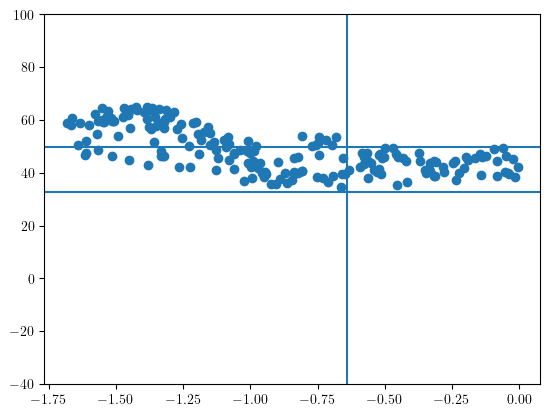

In [61]:
p = Omega_b_mean
gradient = (1 + p**2 / (1 + p**2) * alpha) * Omega_b_mean
angle_deg = np.arctan(gradient) * 180/np.pi

# Corotation energy
Rgrid = np.linspace(0.01, 20, 1000)
Omega_c = v_c(Rgrid) / Rgrid
R_CR = Rgrid[np.argmin(abs(Omega_c - Omega_b[-1]))]
E_CR = 0.5 * v_c(R_CR)**2 + Phi(R_CR)

plt.scatter(E/1e5, gradient)

plt.axhline(Omega_b[-1])

plt.axhline(Omega_b.mean())

plt.axvline(E_CR/1e5)

plt.ylim(-40, 100)


